Processing...
Done!


Epoch 000, Loss: 1.9504, Train: 0.5286, Val: 0.3360, Test: 0.3600
Epoch 020, Loss: 0.8421, Train: 0.9857, Val: 0.7760, Test: 0.7830
Epoch 040, Loss: 0.6606, Train: 1.0000, Val: 0.7940, Test: 0.7900
Epoch 060, Loss: 0.6022, Train: 1.0000, Val: 0.7900, Test: 0.7980
Epoch 080, Loss: 0.3885, Train: 1.0000, Val: 0.7900, Test: 0.8070
Epoch 100, Loss: 0.4479, Train: 1.0000, Val: 0.7860, Test: 0.7970
Epoch 120, Loss: 0.3623, Train: 1.0000, Val: 0.7780, Test: 0.8020
Epoch 140, Loss: 0.4180, Train: 1.0000, Val: 0.7820, Test: 0.8000
Epoch 160, Loss: 0.3392, Train: 1.0000, Val: 0.7840, Test: 0.8050
Epoch 180, Loss: 0.3683, Train: 1.0000, Val: 0.7800, Test: 0.8090
Epoch 200, Loss: 0.4059, Train: 1.0000, Val: 0.7860, Test: 0.8030


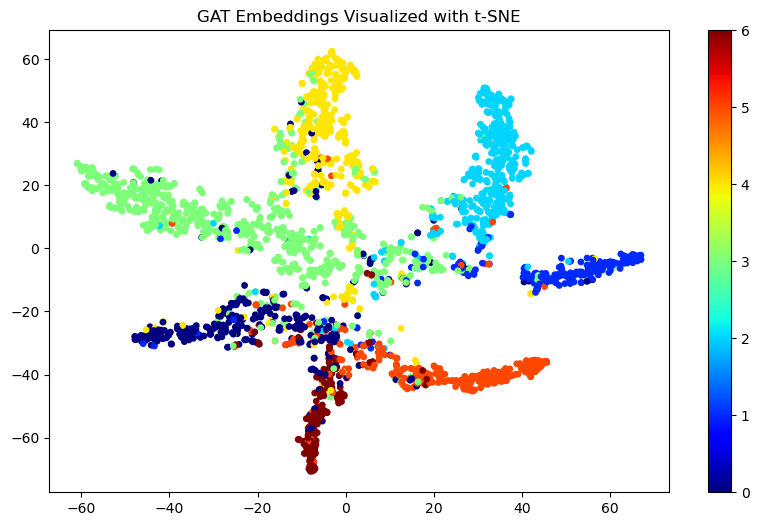

In [1]:
# Install PyTorch Geometric if needed
# !pip install torch-geometric

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load the Cora dataset
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.gat1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.gat2 = GATConv(8 * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GAT(dataset.num_node_features, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs

# Train the model
for epoch in range(201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")

# Visualize embeddings using t-SNE
model.eval()
with torch.no_grad():
    z = model(data.x, data.edge_index).cpu()

z_emb = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(10, 6))
plt.scatter(z_emb[:, 0], z_emb[:, 1], c=data.y.cpu(), cmap="jet", s=15)
plt.colorbar()
plt.title("GAT Embeddings Visualized with t-SNE")
plt.show()
